# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
from tqdm import tqdm_notebook as tqdm

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

results = {}
best_val = -1
best_svm = None
best_params = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for _ in tqdm(range(100)):
    lr = 10**np.random.uniform(-4, 0)
    reg = np.random.exponential(1)

    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
              num_iters=1200, verbose=False)
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)
    train_acc = np.mean(y_train == y_train_pred)
    val_acc = np.mean(y_val == y_val_pred)
    print('lr=%s, reg=%s; accuracy: %s' % (lr, reg, val_acc))
    results[(lr, reg)] = train_acc, val_acc
    if val_acc > best_val:
        best_val = val_acc
        best_svm = svm
        best_params = {'lr': lr, 'reg': reg}

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr=0.006272722790637064, reg=0.6571324587240308; accuracy: 0.484

lr=0.38012015202286603, reg=2.110563148925649; accuracy: 0.04

lr=0.04210431909413956, reg=1.1932334025806948; accuracy: 0.442

lr=0.015912014394293843, reg=0.5698634410206282; accuracy: 0.473

lr=0.00020100098847889176, reg=0.2924309423284212; accuracy: 0.453

lr=0.08759489792017863, reg=0.31247427977843717; accuracy: 0.423

lr=0.00015054726942583983, reg=0.2135577867720613; accuracy: 0.449

lr=0.0022175264515324716, reg=1.5727357960635633; accuracy: 0.461

lr=0.009210626877415307, reg=0.034402309023241866; accuracy: 0.486



/home/not_a_robot/.local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/linear_svm.py:87: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/linear_svm.py:83: RuntimeWarning: overflow encountered in subtract
  margins = np.maximum(0, scores - y_true_scores.reshape(-1, 1) + 1)
/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/linear_svm.py:83: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores - y_true_scores.reshape(-1, 1) + 1)
/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/linear_svm.py:103: RuntimeWarning: invalid value encountered in greater
  coef_mat[margins > 0] = 1.
/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/linear_svm.py:108: R

lr=0.5177779243005253, reg=3.7985024369839793; accuracy: 0.087

lr=0.015587269976269158, reg=1.7257832584456598; accuracy: 0.475

lr=0.6351430097052789, reg=1.06462047989284; accuracy: 0.181

lr=0.00032879308683928904, reg=0.06911469730639556; accuracy: 0.465

lr=0.007248941929416522, reg=0.1960389919337328; accuracy: 0.489

lr=0.0018993136219665908, reg=1.2392546669208686; accuracy: 0.472

lr=0.007102185501604907, reg=1.5115845896140552; accuracy: 0.454

lr=0.0004892941427106623, reg=0.14141874780519723; accuracy: 0.476

lr=0.008879475389692077, reg=1.0264782987004; accuracy: 0.457

lr=0.001543807892918048, reg=0.705376956249011; accuracy: 0.477

lr=0.00010120752827375532, reg=1.553247007382178; accuracy: 0.441

lr=0.0027466202683805803, reg=0.7108948350638877; accuracy: 0.473

lr=0.00014908995745017834, reg=0.07723838019563047; accuracy: 0.45

lr=0.0025803425353188698, reg=0.2723106685346309; accuracy: 0.483

lr=0.00018456323207934858, reg=0.9068902335612399; accuracy: 0.449

lr=0.01

/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/linear_svm.py:87: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)


lr=0.5654512172551449, reg=2.6896982063532096; accuracy: 0.087

lr=0.005796933225182937, reg=0.6091729653842086; accuracy: 0.482

lr=0.10187123424597803, reg=2.899341324722702; accuracy: 0.329

lr=0.21475229969312046, reg=0.5432706248750307; accuracy: 0.382

lr=0.532994775821676, reg=0.6953137299764743; accuracy: 0.207

lr=0.01718350089880639, reg=1.6700530319960374; accuracy: 0.446

lr=0.4534008801878835, reg=0.06928663042370896; accuracy: 0.385

lr=0.14964735271226529, reg=1.633979054052258; accuracy: 0.367

lr=0.0009528656877609404, reg=0.6689732067018882; accuracy: 0.477

lr=0.2760278304089051, reg=0.3208173089044484; accuracy: 0.372

lr=0.07687063652862246, reg=1.2313880432416087; accuracy: 0.431

lr=0.005661605529989784, reg=0.5676569311396694; accuracy: 0.474

lr=0.00029627590828751245, reg=1.3315854634715585; accuracy: 0.457

lr=0.00656037094042545, reg=0.551789359191461; accuracy: 0.493

lr=0.00035544233337134315, reg=1.3734468647644487; accuracy: 0.458

lr=0.09331187931964881

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.483


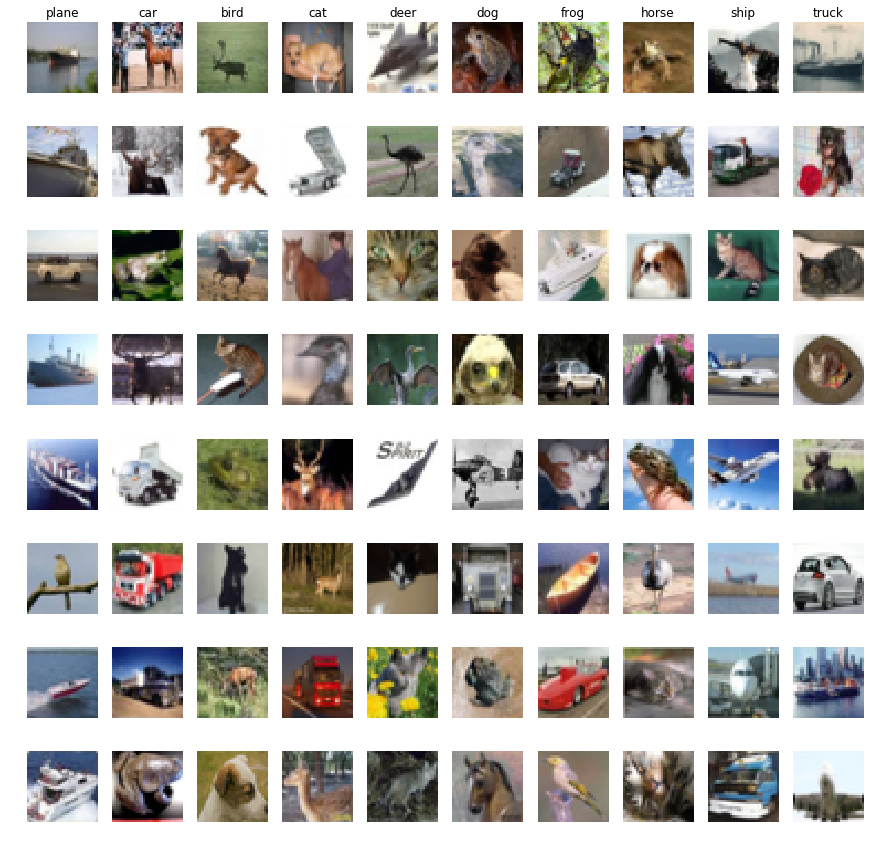

In [13]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
plt.figure(figsize=(12, 12))

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

It seems that the model rely on the background too much and it definetly tend to misclassify planes and ships, but sometimes the answers does not make any sense like (bird, 2) image with a dog.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [ ]:
hist = []

best_acc = 0
best_params = {}
best_stats = None
best_net = None


Params:  {'hidden': 197, 'lr': 0.45454024553631545, 'decay': 0.9987165131728902, 'reg': 0.6493662190571033}
Validation accuracy:  0.107


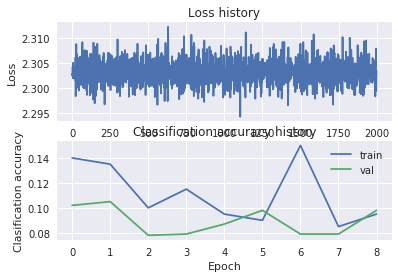

Params:  {'hidden': 172, 'lr': 0.1394681435341563, 'decay': 0.9992555210118129, 'reg': 0.037821300211228766}
Validation accuracy:  0.459


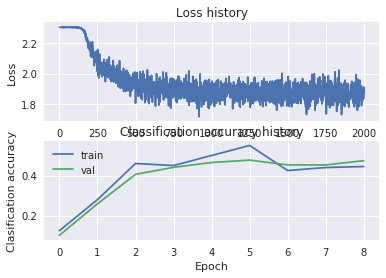

Params:  {'hidden': 145, 'lr': 0.5401755450511905, 'decay': 0.9926510665355026, 'reg': 0.8444056617986114}
Validation accuracy:  0.112


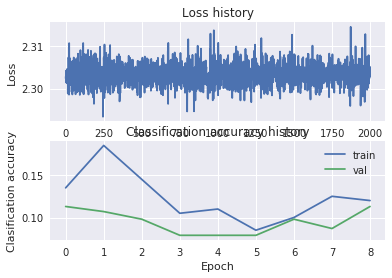

Params:  {'hidden': 182, 'lr': 0.295349855285253, 'decay': 0.9950116639124894, 'reg': 1.330814071085982}
Validation accuracy:  0.098


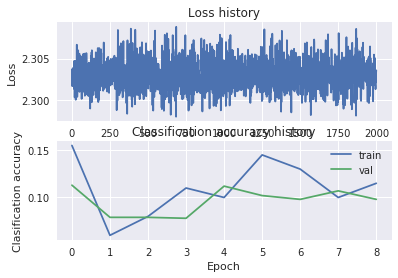

Params:  {'hidden': 193, 'lr': 0.06867978708168228, 'decay': 0.9925777437037937, 'reg': 1.600280259327986}
Validation accuracy:  0.078


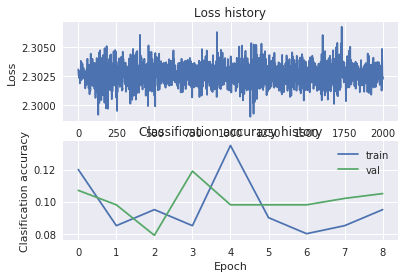

Params:  {'hidden': 155, 'lr': 0.2704321330620282, 'decay': 0.9989696779033288, 'reg': 0.2644120106285663}
Validation accuracy:  0.078


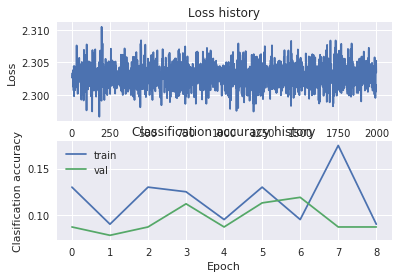

Params:  {'hidden': 122, 'lr': 0.9070789544887566, 'decay': 0.9943530687351114, 'reg': 1.139234014587218}


/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/neural_net.py:101: RuntimeWarning: overflow encountered in exp
  exp_f = np.exp(f + np.max(f, axis=1, keepdims=True))
/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/neural_net.py:103: RuntimeWarning: divide by zero encountered in log
  loss -= np.sum(np.log(exp_f[range(num_train), y] / norm))
/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/neural_net.py:119: RuntimeWarning: invalid value encountered in true_divide
  softmax_scores = exp_f / norm.reshape(-1, 1)  # (num_train, num_classes)
/home/not_a_robot/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/not_a_robot/Documents/cs231n/assignment1/cs231n/classifiers/neural_net.py:134: RuntimeWarning: invalid value encountered in greater
  dW1 = X.T @ (dh * (h_pre > 0))
/home/not_a_robot/Documents/cs231n/assignment1/cs2

Validation accuracy:  0.087


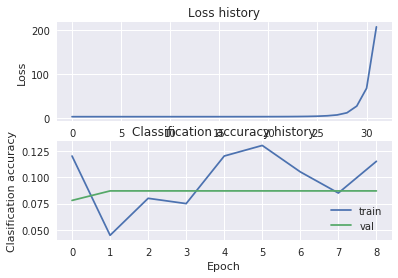

Params:  {'hidden': 190, 'lr': 0.06614716870715717, 'decay': 0.9980792680216461, 'reg': 0.8289592996648217}
Validation accuracy:  0.119


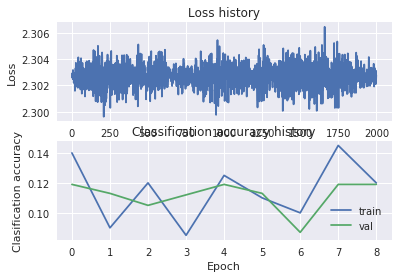

Params:  {'hidden': 169, 'lr': 0.09163825917364793, 'decay': 0.9948878514993663, 'reg': 0.3883569584338475}
Validation accuracy:  0.087


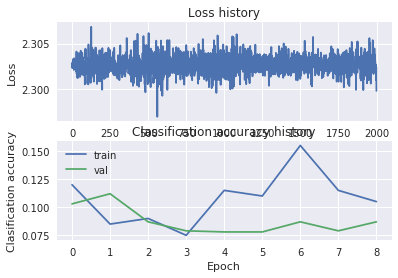

Params:  {'hidden': 143, 'lr': 0.06119556202183235, 'decay': 0.9933568423991603, 'reg': 0.37517235788772885}
Validation accuracy:  0.105


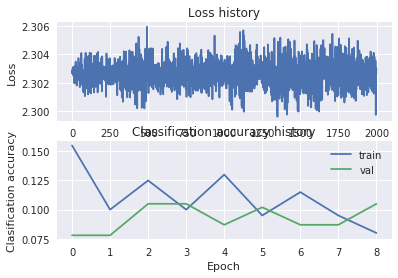

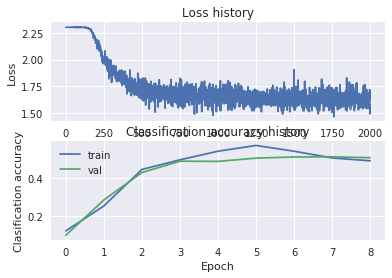

0.505


In [80]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for _ in tqdm(range(10)):
    hidden = int(np.random.uniform(120, 200))
    log_lr = np.random.uniform(-1.3, 0)
    decay = np.random.uniform(0.992, 1)
    reg = np.random.exponential(1)

    params = {'hidden': hidden, 'lr': 10**log_lr, 'decay': decay, 'reg': reg}
           #, 'batch_size': batch_size, 'num_iters': num_iters}
    print('Params: ', params)
    # Train the network
    net = TwoLayerNet(input_dim, hidden, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=2000, batch_size=200,
                learning_rate=10**log_lr, learning_rate_decay=decay,
                reg=reg, verbose=False)

    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    print('Validation accuracy: ', val_acc)

    params['val_acc'] = val_acc
    hist.append(params)

    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.legend()
    plt.show()
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_net = net
        best_stats = stats
        best_params = params

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

print(best_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

%matplotlib inline

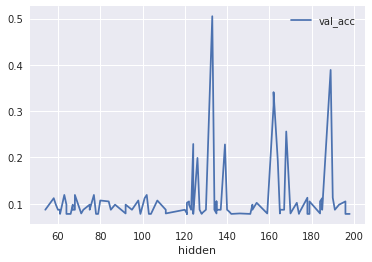

In [66]:
hist_df.sort_values('hidden').plot('hidden', 'val_acc')

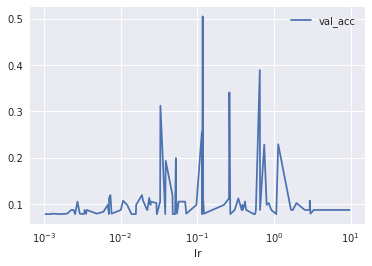

In [67]:
hist_df.sort_values('lr').plot('lr', 'val_acc', logx=True)

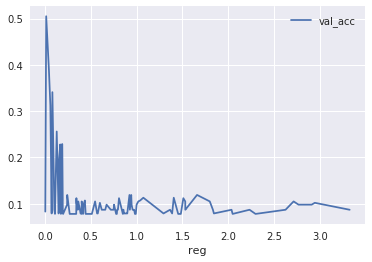

In [70]:
hist_df.sort_values('reg').plot('reg', 'val_acc')

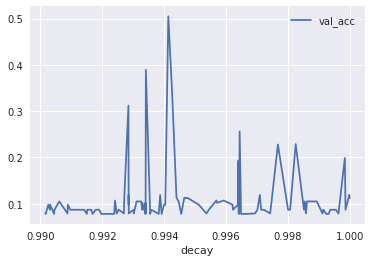

In [79]:
hist_df.sort_values('decay').plot('decay', 'val_acc')

In [71]:
hist_df.sort_values('val_acc', ascending=False).head(10)

,decay,hidden,lr,reg,val_acc
83,0.994134,133,0.117585,0.014879,0.505
99,0.993408,189,0.653728,0.044669,0.389
68,0.994256,162,0.262152,0.082462,0.341
2,0.992846,162,0.033040,0.060385,0.312
49,0.996437,168,0.114753,0.129655,0.256
80,0.998248,124,1.136076,0.189368,0.229
75,0.997673,139,0.747087,0.168018,0.228
92,0.999836,126,0.052557,0.156813,0.199
17,0.996397,164,0.038778,0.154996,0.193
78,0.993870,68,0.018966,1.658981,0.119


In [81]:
best_params

{'hidden': 133,
 'lr': 0.11758545991351277,
 'decay': 0.9941335046540989,
 'reg': 0.014879062733366187,
 'val_acc': 0.505}

iteration 0 / 2000: loss 2.308755
iteration 100 / 2000: loss 1.423520
iteration 200 / 2000: loss 1.252659
iteration 300 / 2000: loss 1.230188
iteration 400 / 2000: loss 1.310890
iteration 500 / 2000: loss 1.279508
iteration 600 / 2000: loss 1.262839
iteration 700 / 2000: loss 1.293288
iteration 800 / 2000: loss 1.070931
iteration 900 / 2000: loss 1.128876
iteration 1000 / 2000: loss 1.085166
iteration 1100 / 2000: loss 0.865156
iteration 1200 / 2000: loss 1.160040
iteration 1300 / 2000: loss 0.859985
iteration 1400 / 2000: loss 0.959810
iteration 1500 / 2000: loss 1.041654
iteration 1600 / 2000: loss 0.897276
iteration 1700 / 2000: loss 0.909504
iteration 1800 / 2000: loss 0.934908
iteration 1900 / 2000: loss 0.947745
Validation accuracy:  0.607


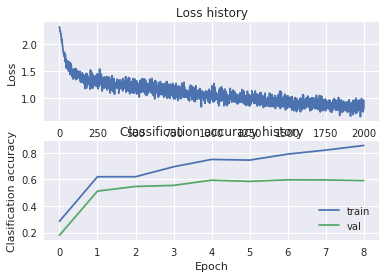

In [151]:
net = TwoLayerNet(input_dim, 2048, num_classes, std=1e-2)
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=2e-1, learning_rate_decay=0.99,
            reg=0.0001, verbose=True)

# Predict on the validation set
train_acc = (net.predict(X_train_feats) == y_train).mean()
val_acc = (net.predict(X_val_feats) == y_val).mean()

print('Validation accuracy: ', val_acc)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [152]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.581
